# Poster Notebook: Histogram of associations between Protein/Gene Expression and Clinical Features
```
Created: 09-20-2020
URL:     https://github.com/isb-cgc/Community-Notebooks/blob/master/FeaturedNotebooks/ACM_BCB_2020_POSTER_Histogram_Associations_ProteinGeneExpression_vs_ClinicalFeatures.ipynb
Notes: This notebook supports the POSTER : "Multi-omics Data Integration in the Cloud: Analysis 
of Statistically Significant Associations Between Clinical and Molecular Features in Breast Cancer" 
by K. Abdilleh, B. Aguilar, and R. Thomson , presented in the ACM Conference on Bioinformatics, 
Computational Biology, and Health Informatics, 2020.
```
***

This Notebook computes statistically significant associations between Protein/Gene expression and clinical features of Breast cancer, using data available in TCGA BigQuery tables.

The associations were computed using the Kruskal Wallis (KW) test, implemented as user defined function in Bigquery. Details of the KW test and its implementatin can be found in: https://github.com/jrossthomson/bigquery-utils/tree/master/udfs/statslib

A histogram of the number of cases with significant associations is generated after the Kruskal Wallis test. 


# Setup

In [ ]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_gbq

#! {sys.executable} -m pip install matplotlib seaborn
#! {sys.executable} -m pip install google-cloud
#! {sys.executable} -m pip install google-cloud
#! {sys.executable} -m pip install google-auth
print({sys.executable})
from platform import python_version

print(python_version())

{'/usr/bin/python3'}
3.6.9


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Authentication
The first step is to authorize access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html) and alternative authentication methods can be found [here](https://googleapis.github.io/google-cloud-python/latest/core/auth.html).

In [ ]:
from google.colab import auth
import google.auth

auth.authenticate_user()
my_project_id = "" # write your project id here

#credentials, your_project_id = google.auth.default()


# Number of proteins with significant associations with Clinical feateures

In [ ]:
cancer_type = 'TCGA-BRCA' # https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/tcga-study-abbreviations
significance_level = '0.001'
sql = '''
with the_goods as (
  SELECT p.project_short_name as study, gene_name as g, c.feature.key as c, `isb-cgc-bq.functions.kruskal_wallis_current`(array_agg((c.feature.value,protein_expression))) as reso
  FROM `isb-cgc.TCGA_hg19_data_v0.Protein_Expression` p
  JOIN `isb-cgc-bq.supplementary_tables.Abdilleh_etal_ACM_BCB_2020_TCGA_bioclin_v0_Clinical_UNPIVOT` c
  ON c.case_barcode = substr(p.sample_barcode,0,12)
  WHERE 1=1 AND c.feature.value != "null" AND p.project_short_name = "{0}"
  GROUP BY study, g, c
  HAVING reso.DoF >2 and reso.DoF < 10 and reso.p <= {1}
  ORDER BY study, reso.p, c
) # the_goods
select c as Clinical_feature, COUNT(g) as Protein 
from the_goods
group by c
order by Protein DESC
'''.format( cancer_type , significance_level )
df1 = pandas_gbq.read_gbq(sql,project_id=my_project_id )
df1


,Clinical_feature,Protein
0,histological_type,59
1,race,41
2,menopause_status,12
3,pathologic_M,1
4,anatomic_neoplasm_subdivision,1
5,country,1


# Number of Genes with expressions that are significantly associated with Clinical feateures


In [ ]:
sql = '''
with the_goods as (
  SELECT p.project_short_name as study, p.HGNC_gene_symbol as g, c.feature.key as c, `isb-cgc-bq.functions.kruskal_wallis_current`(array_agg((c.feature.value,normalized_count))) as reso
  FROM `isb-cgc.TCGA_hg19_data_v0.RNAseq_Gene_Expression_UNC_RSEM` p
  JOIN `isb-cgc-bq.supplementary_tables.Abdilleh_etal_ACM_BCB_2020_TCGA_bioclin_v0_Clinical_UNPIVOT` c
  ON c.case_barcode = substr(p.sample_barcode,0,12)
  WHERE 1=1 AND c.feature.value != "null" AND p.project_short_name = "{0}"
        and HGNC_gene_symbol in ( SELECT gene_name FROM `isb-cgc.TCGA_hg19_data_v0.Protein_Expression` GROUP BY 1 )
  GROUP BY study, g, c
  HAVING reso.DoF >2 and reso.DoF < 10 and reso.p <= {1}
  ORDER BY study, reso.p, c
) # the_goods
select c as Clinical_feature, COUNT(g) as Gene_expression 
from the_goods
group by c
order by Gene_expression DESC
'''.format( cancer_type , significance_level )
df2 = pandas_gbq.read_gbq(sql, project_id=my_project_id)
df2


,Clinical_feature,Gene_expression
0,histological_type,159
1,race,126
2,pathologic_M,50
3,menopause_status,23
4,anatomic_neoplasm_subdivision,2


# Plot histogram

Text(0.5, 0, 'Clinical feature')

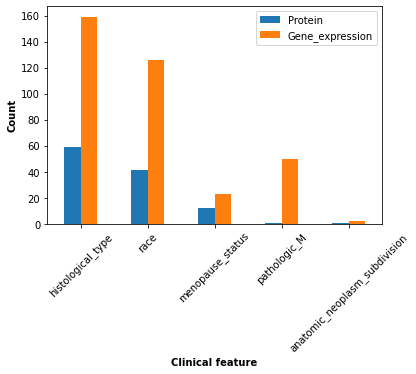

In [ ]:
# join tables
df = df1.set_index('Clinical_feature').join(df2.set_index('Clinical_feature'), how='inner')
# Generate plot
ax = df.plot.bar(rot=45)
plt.ylabel('Count', fontweight='bold')
plt.xlabel('Clinical feature', fontweight='bold')